<a href="https://colab.research.google.com/github/MasaAsami/carryover_effect_eda/blob/main/carryover_bias_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title import pkg { display-mode: "form" }
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', palette='deep')
%matplotlib inline

$$
\begin{align}
X_{i1} &:=-\alpha_i + \epsilon_{i1x} \\
Y_{i1} &:= \alpha_i + \beta * X_{i1} + \epsilon_{i1y} \\
X_{i2} &:=-\alpha_i + \gamma * Y_{i1} + \epsilon_{i2x} \\
Y_{i2} &:=\alpha_i + \beta * X_{i2} + \epsilon_{i2y} \\
\end{align}
$$

In [3]:
#@title simulation data { display-mode: "form" }
def sim_data(_beta=1, _gamma=1, _seed=123, n=1000) -> pd.DataFrame:
    np.random.seed(_seed)
    ui = np.random.normal(0, 1, n)
    unit = np.array(range(n))

    x1 = np.random.normal(ui * -1, 1, n)
    y1 = np.random.normal(_beta * x1 + ui, 1, n)

    x2 = np.random.normal(ui * -1 + x1 + _gamma * y1, 1, n)
    y2 = np.random.normal(_beta * x2 + ui, 1, n)

    return pd.concat(
        [
            pd.DataFrame(dict(y=y1, x=x1, t=1, i=unit)),
            pd.DataFrame(dict(y=y2, x=x2, t=2, i=unit)),
        ]
    )

In [4]:
#@title simulation function { display-mode: "form" }
def sim_result(_beta, _gamma, sim_n=100):
    naive_ols_result = []
    fixed_effect_result = []
    for _s in range(sim_n):
        _df = sim_data(_beta, _gamma, _seed=_s)
        naive_ols_result.append(smf.ols("y~x", data=_df).fit().params["x"])
        fixed_effect_result.append(smf.ols("y~x + C(i)", data=_df).fit().params["x"])

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), facecolor="w", edgecolor="k")

    axs[0].set_title(
        f"naive ols : abs mean error = {np.abs(_beta - np.mean(naive_ols_result)) : .3f}"
    )
    axs[0].hist(naive_ols_result, label="naive ols")
    axs[0].axvline(x=_beta, color="red", linestyle="--")
    axs[1].set_title(
        f"fixed effect : abs mean error = {np.abs(_beta - np.mean(fixed_effect_result)) : .3f}"
    )
    axs[1].hist(fixed_effect_result, label="fixed effect")
    axs[1].axvline(x=_beta, color="red", linestyle="--")
    plt.show()
    print(f"naive ols :{np.mean(naive_ols_result): .3f}")
    print(f"fixed effect model :{np.mean(fixed_effect_result): .3f}")
    return naive_ols_result, fixed_effect_result

## no carryover
$\beta=1, \gamma = 0$

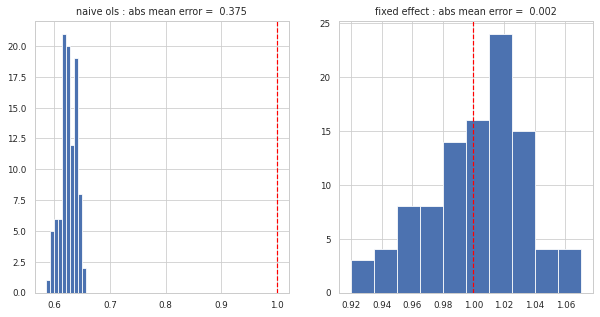

naive ols : 0.625
fixed effect model : 1.002


In [5]:
_, _ = sim_result(1, 0, sim_n=100)

## with carryover  $Y_{i1}$ -> $X_{i2}$

$\beta=1, \gamma = 0.5$

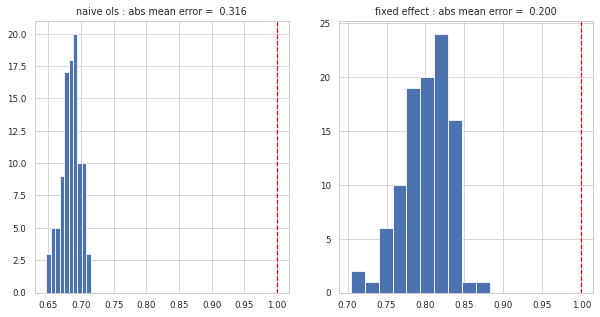

naive ols : 0.684
fixed effect model : 0.800


In [6]:
_, _ = sim_result(1, 0.5, sim_n=100)

## Why can't we estimate it well?

- Check the following paper : 
Sjölander, Arvid, et al. "[Carryover effects in sibling comparison designs.](https://journals.lww.com/epidem/Fulltext/2016/11000/Carryover_Effects_in_Sibling_Comparison_Designs.12.aspx)"Epidemiology 27.6 (2016): 852-858.

- $\hat \beta_{ide}$ converges to the following function：
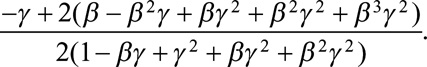

> "Clearly, there is no guarantee that conditional maximum likelihood estimator is conservative even under this simple data generating model, or that it provides a valid test of the null hypothesis."

In [8]:
def beta_ide(_beta, _gamma):
    return (
        -1 * _gamma
        + 2
        * (
            _beta
            - _beta ** 2 * _gamma
            + _beta * _gamma ** 2
            + _beta ** 2 * _gamma ** 2
            + _beta ** 3 * _gamma ** 2
        )
    ) / (
        2
        * (
            1
            - _beta * _gamma
            + _gamma ** 2
            + _beta * _gamma ** 2
            + _beta ** 2 * _gamma ** 2
        )
    )

In [10]:
print("no carryover :", beta_ide(1, 0))
print("with carryover (gamma : 0.5) :", beta_ide(1, 0.5))

no carryover : 1.0
with carryover (gamma : 0.5) : 0.8
